In [99]:
#%matplotlib inline
%matplotlib notebook

import csv
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import collections

dsname = "bw"
queryType = "text.setops"

o_fnf = "../../data/logs/create/{name}.{ref}.substring.benchmark.oscar.{cqr}.osi-{qt}.raw"
sg_fnf = "../../data/logs/create/{name}.disconnected.substring.osi.{sg}.benchmark.{cqr}.{qt}.{sg}.stats.raw"
q_fnf = "../../data/queries/website/filtered/{name}.{qt}.txt"
qs_fnf = "../../data/stats/queries/{name}.{qt}.osi.stats.raw"

def read_csv(fn):
    return pd.read_csv(fn.format(dsname), delimiter=';')

queries = []

with open(q_fnf.format(name=dsname, qt=queryType)) as f:
    tmp = [line for line in f] + [""]
    queries = pd.DataFrame({"Query id" : range(0, len(tmp)), "Query": tmp})

queryStats = pd.read_csv(qs_fnf.format(name=dsname, qt=queryType), delimiter=";")
    
d = {}

for x in ["cqr", "tcqr"]:
    d[x] = {}
    for y in ["disconnected", "nocellsplit", "cellsplit1k", "celldiag5k"]:
        ofn = o_fnf.format(name=dsname, ref=y, cqr=x, qt=queryType)
        try:
            tmp = pd.read_csv(ofn, delimiter=";")
            d[x][y] = tmp
        except:
            print("Failed to parse file {}".format(ofn))
            pass
    for y in ["htm", "h3", "simplegrid"]:
        sgfn = sg_fnf.format(name=dsname, sg=y, cqr=x, qt=queryType)
        try:
            tmp = pd.read_csv(sgfn, delimiter=";")
            d[x][y] = tmp
        except:
            print("Failed to parse file {}".format(sgfn))
            pass


In [104]:
# find out which of the many cell arrangements produce the best completion times
dfa = pd.DataFrame({"Query id": range(0, len(queries))})
rk = ["h3", "htm", "simplegrid",
        "celldiag5k",
#        "cellsplit1k",
#       "nocellsplit",
#        "disconnected"
    ]
#rk = ["nocellsplit", "disconnected"]
for x in rk:
    dfa[x] = d["cqr"][x][" cqr time [us]"]
oreft=["disconnected", "nocellsplit", "cellsplit1k", "celldiag5k"]
hist = dict([(x, 0) for x in d["cqr"].keys()] + [("oscar", 0)])
for x in dfa[rk].idxmin(axis=1):
    if x in hist:
        hist[x] += 1
    if x in oreft:
        hist["oscar"] += 1
hist

print("{oscar}\t\t&{htm}\t&{h3}\t&{grid}\\\\".format(oscar=hist["oscar"], htm=hist["htm"], h3=hist["h3"],grid=hist["simplegrid"]))

#help(pd.merge)

805		&349	&436	&264\\


In [32]:
cqrt = "cqr"
ft = "h3"
st = "htm"
colname = " cqr time [us]"

fd = d[cqrt][ft]
sd = d[cqrt][st]

tmp = (fd[colname] - sd[colname])
print("Min: {}, Max: {}".format(tmp.min(), tmp.max()))
dfc = pd.merge(fd[["Query id", " cqr time [us]"]], od[["Query id", " cqr time [us]"]], how="outer", on="Query id")
dfc = pd.merge(dfc, queries, how="left", on="Query id")
dfc = pd.merge(dfc, queryStats, how="left", on="Query id")
regionqueries = queries["Query"].str.contains("#")
len(regionqueries)
len(dfc)
#dfc.dtypes
#dfc[(regionqueries) & (tmp > 0)]
threshold = 100
for i in range(0, 7):
    f_faster = dfc[(tmp < -threshold) & (dfc["intersect"] > i)]
    s_faster = dfc[(tmp > threshold) & (dfc["intersect"] > i)]
    print("{} intersections: {}:{}".format(i, len(f_faster), len(s_faster)))


Min: -479290.0, Max: 362740.0
0 intersections: 2298:344
1 intersections: 851:70
2 intersections: 241:11
3 intersections: 72:1
4 intersections: 17:0
5 intersections: 3:0
6 intersections: 0:0


<IPython.core.display.Javascript object>


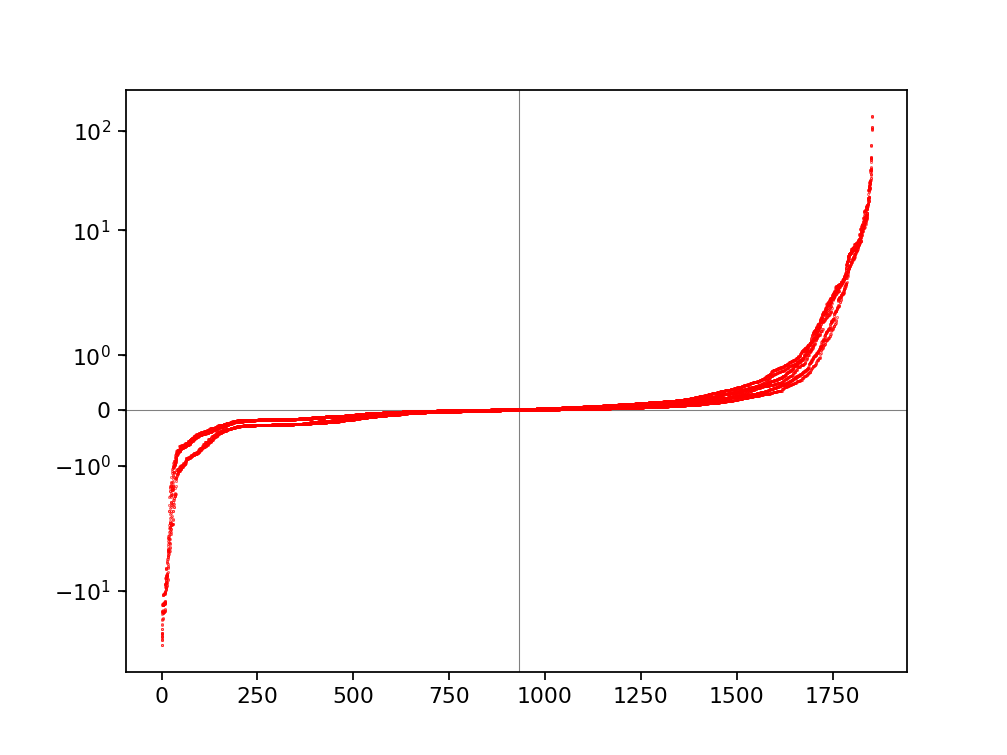

In [107]:
#colname = "flaten time[us]"
colname = " cqr time [us]"
cqrt = "cqr"

diff = dict()

x_axis = range(0, len(queries))
plt.yscale('symlog')
plt.axvline(x=len(x_axis)/2, color="grey", linewidth=0.5)
plt.axhline(y=0, color="grey", linewidth=0.5)


for oscar in ["disconnected", "nocellsplit", "cellsplit1k"]:
    for sg in ["htm", "h3", "simplegrid"]:
        diff = (d[cqrt][sg][colname] - d[cqrt][oscar][colname]).sort_values()/1000
        plt.plot(range(0, len(diff)), diff, 'r.', linestyle=None, linewidth=0.0, markersize=0.5)
        
plt.show()